In [4]:
import docx
import pandas as pd
import numpy as np


In [5]:
# open an existing document

doc = docx.Document('breast-cancer-wisconsin.docx')
result = [p.text for p in doc.paragraphs]
result[0]

'Index,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class'

In [10]:
rows = len(doc.paragraphs)
num_var = 12

In [11]:
columns = []
columns_string = result[0]
for r in range(num_var):
    str1 = columns_string.partition(',')
    columns.append(str1[0])
    columns_string = str1[2]
print(columns)

['Index', 'ID', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']


In [12]:
# a function to get numbers from rows

def getRow(new_string, num_columns):
    data = []
    for i in range(num_columns):
        str1 = new_string.partition(',')
        try:
            data.append(int(str1[0]))
        except ValueError:
            data.append(np.nan)
        new_string = str1[2]
    return data


In [13]:
# get all rows
df = pd.DataFrame(columns=columns) # create columns in the dataframe
data_string = result[1:] # get all data rows

num_columns = len(columns)
num_rows = len(result)-1

for r in range(num_rows):
    new_string = data_string[r] # get next data row
    data = getRow(new_string, num_columns)
    df = df.append(pd.DataFrame(np.array([data]),columns = columns), ignore_index=True)


df = df.drop("Index", axis=1) # remove Index, redundant    
df.describe()

,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,15855.0,15855.0,15776,15776,15776.0,15776.0,15760,15776,15776,15776,15776
unique,666.0,17.0,18,16,17.0,16.0,16,16,19,11,4
top,1198641.0,10.0,10,4,3.0,3.0,10,3,1,1,4
freq,1003.0,5070.0,4051,4022,4035.0,6043.0,5123,6132,2430,10527,15164


* Find 40 and chage it to 4, find 20 and change it to 2
* Drop rows that have NaNs

In [15]:
# drop nan Class + fix
df = df.dropna(axis = 0)
df['Class'].replace(40, 4, inplace=True)
df['Class'].replace(20, 2, inplace=True)
df.loc[(df['Class'] != 2) & (df['Class'] != 4)]


,ID,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class


* change category of predictor

In [16]:
# fill missing values with columns means
df = df.fillna(df.mean())
df['Class'] = df['Class'].astype('category',copy=False)

In [17]:
X = df.drop(['ID', 'Class'], axis = 1)
y = df['Class']
y = label_binarize(y, classes=[2, 4])



NameError: name 'label_binarize' is not defined

In [116]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import RandomOverSampler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

from imblearn.over_sampling import SMOTE
import statsmodels.api as sm

columns = X_train.columns
#os = SMOTE(random_state = 0)
#os_data_X,os_data_y = os.fit_sample(X_train, y_train)
ros = RandomOverSampler(random_state=0, oversample = 'minority')
os_data_X,os_data_y = ros.fit_resample(X_train, y_train)
os_data_X = pd.DataFrame(data = os_data_X,columns = columns )
os_data_y = pd.DataFrame(data = os_data_y,columns = ['Class'])


model = RandomForestClassifier(class_weight = 'balanced')
parameters = {'n_estimators'    : sp_randInt(100, 500),
                  'max_features'    : sp_randInt(1,5),
                  'min_samples_split' : sp_randInt(5, 30),
                  'max_depth'    : sp_randInt(4, 10)
                 }

randm = RandomizedSearchCV(estimator=model, param_distributions = parameters,
                               cv = 2, n_iter = 10, n_jobs=-1)


In [117]:
randm.fit(os_data_X, os_data_y)

/Users/iryna/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


RandomizedSearchCV(cv=2,
                   estimator=RandomForestClassifier(class_weight='balanced'),
                   n_jobs=-1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1bf0f790>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1bf09b90>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1d472f90>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1b669f50>})

In [118]:
print("\n========================================================")
print(" Results from Random Search " )
print("========================================================")
print("\n The best estimator across ALL searched params:\n",
          randm.best_estimator_)
print("\n The best score across ALL searched params:\n",
          randm.best_score_)
print("\n The best parameters across ALL searched params:\n",
          randm.best_params_)
print("\n ========================================================")


 Results from Random Search 

 The best estimator across ALL searched params:
 RandomForestClassifier(class_weight='balanced', max_depth=9, max_features=1,
                       min_samples_split=9, n_estimators=474)

 The best score across ALL searched params:
 0.9992539401286953

 The best parameters across ALL searched params:
 {'max_depth': 9, 'max_features': 1, 'min_samples_split': 9, 'n_estimators': 474}



In [119]:
clf = RandomForestClassifier(class_weight='balanced',max_depth=9, max_features=1,
                       min_samples_split=9, n_estimators=474)
RF_model = clf.fit(os_data_X, os_data_y)

/Users/iryna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [120]:
RF_model.score(X_test,y_test)

0.998942470389171

In [121]:
y_predict = RF_model.predict(X_test)
y_predict.mean()

0.9701776649746193

In [122]:
# Extract feature importances
fi = pd.DataFrame({'feature': list(X_train.columns),
                   'importance': RF_model.feature_importances_}).\
                    sort_values('importance', ascending = False)

# Display
fi.head()

,feature,importance
1,Uniformity of Cell Size,0.184733
2,Uniformity of Cell Shape,0.162985
4,Single Epithelial Cell Size,0.121129
0,Clump Thickness,0.112316
5,Bare Nuclei,0.110994


In [123]:
# plot a ROC curve for each class

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
y = label_binarize(y, classes=[2, 4])
n_classes = y.shape[1]
n_samples, n_features = X.shape


In [126]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm

classifier = OneVsRestClassifier(clf)
y_score = classifier.fit(os_data_X, os_data_y).predict_proba(X_test)

In [127]:
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

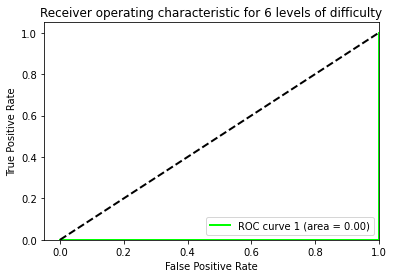

In [128]:
import matplotlib.pyplot as plt
lw = 2
colors = ['lime', 'lightseagreen', 'royalblue', 'mediumblue', 'black', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for 6 levels of difficulty')
plt.legend(loc="lower right")
plt.savefig('ROC curve')
plt.show()

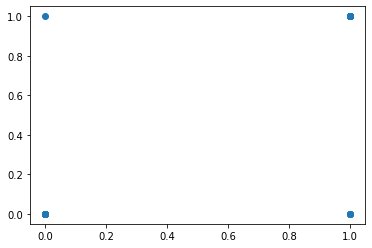

In [129]:
plt.figure()
plt.scatter(y_test, y_predict)
plt.show()

In [130]:
import pickle
pkl_filename = "pickle_data.pkl"
with open(pkl_filename, 'wb') as file:   
    pickle.dump(df, file)